# Import packages

In [1]:
import numpy as np
import requests
from datetime import date
import time
import math
import os
import ast
import json
import osm2geojson
import matplotlib.pyplot as plt
from mlxtend.plotting import scatterplotmatrix
from mlxtend.plotting import heatmap
import pandas as pd
import tqdm
import seaborn as sns
import folium
import geopandas as gpd
import fiona
from shapely.geometry import Point
import logging
from collections import defaultdict
import overpy
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
%matplotlib inline



# Load housing data from Boligsiden API

In [2]:
def log(response, logfile, output_path=os.getcwd()):
    """# Logging function to gather the log information"""
    # Open or create the csv file
    if os.path.isfile(logfile): #If the log file exists, open it and allow for changes     
        log = open(logfile,'a')
    else: #If the log file does not exist, create it and make headers for the log variables
        log = open(logfile,'w')
        header = ['timestamp','status_code','length','output_file']
        log.write(';'.join(header) + "\n") #Make the headers and jump to new line
        
    # Gather log information
    status_code = response.status_code #Status code from the request result
    timestamp = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())) #Local time
    length = len(response.text) #Length of the HTML-string
    
    # Open the log file and append the gathered log information
    with open(logfile,'a') as log:
        log.write(f'{timestamp};{status_code};{length};{output_path}' + "\n") #Append the information and jump to new line

In [3]:
year_from = 2000 # Determine start year
# municipality_codes = [101, 147] # codes for Copenhagen and Frederiksberg
# total_pages = [] # list to store pages

# base_url = 'https://api.boliga.dk/api/v2/sold/search/results'
# for i in range(0, len(municipality_codes)):
#     query_url = f'?propertyType=1,2,3,9&municipality={municipality_codes[i]}&salesDateMin={year_from}&salesDateMax=today&sort=date-d&page=1'
#     url1 = base_url + query_url
#     response = requests.get(url1, headers={'name':'Julius Løve fischer','email':'nbm205@alumni.ku.dk'}).json()
#     total_pages.append(response['meta']['totalPages'])

# print(response['meta'])

In [4]:
# query_urls = [] # list to contain query_urls for main data
# [[query_urls.append(f'?propertyType=1,2,3&municipality={municipality}&salesDateMin={year_from}&salesDateMax=today&sort=date-d&page={page_num}')\
#               for page_num in range(1, pages + 1)] for municipality, pages in zip(municipality_codes, total_pages)]

# query_urls_extra = [] # list to contain query_urls for extra housing information using Boliga BBR database
# [[query_urls_extra.append(f'?propertyType=1,2,3,9&municipality={municipality}&salesDateMin={year_from}&salesDateMax=today&sort=date-d&page={page_num}')\
#               for page_num in range(1, pages + 1)] for municipality, pages in zip(municipality_codes, total_pages)]

def scraper(base_url, query_urls, title, type = ''):
    logfile = f'log{title}.csv'
    df = pd.DataFrame()
    for query_url in tqdm.tqdm(query_urls):
        url = base_url + query_url
        try:
            response = requests.get(url, headers={'name':'Julius Løve fischer','email':'nbm205@alumni.ku.dk'})
        except Exception as e:
            print(url) #Print url
            print(f'An error has occured: {e}') #Print error
            df.to_csv(f'{title}.csv') #Save the dataframe as a csv file to retrieve at another time
            continue #Continue to next iteration of the loop
        
        if response.ok: #Check if the response carries any data
            result_json = response.json() #If the response carries data, then convert it to json format
        else: #If the response does not carry any data, then print the status_code and continue to next iteration of the loop
            print(f'Status code: {response.status_code}')
            continue
        
        if type == 'BBR':
            result_df = pd.Series(result_json) #Convert this iteration's json file to a series
            df = pd.concat([df,result_df], axis=1, ignore_index=True) #Append to the rest of the data
        else:
            result_df = pd.DataFrame(result_json['results']) #Convert this iteration's json file to a dataframe
            df = pd.concat([df,result_df], axis=0, ignore_index=True) #Append to the rest of the data
        log(response, logfile)
        time.sleep(0.1) #Sleep for 0.1 seconds
        
    if type == 'BBR':
        return df.transpose()
    else:
        return df

# houses = scraper(base_url, query_urls, 'houses')
    
# # houses.to_csv('houses.csv', index=False)

# Clean and transform Boliga data

In [5]:
# houses = pd.read_csv('houses.csv')

# column_selection = ['address', 'zipCode', 'price', 'soldDate', 'propertyType',
#             'saleType', 'sqmPrice', 'rooms', 'size', 'buildYear', 'guid', 'latitude',
#             'longitude', 'municipalityCode', 'city']

# houses = houses[column_selection].query("saleType == 'Alm. Salg'") # select relevant columns and sale types
# houses['unitId'] = houses['guid'].str.lower() # Convert to lower case for merging with bbr dataframe
# houses['soldDate'] = pd.to_datetime(houses['soldDate'].astype(str)).dt.date
# houses = houses.sort_values(by="soldDate", ascending = False) # Dataframe is not sorted by default as we have two query_lists

In [6]:
# # Load housing specific details such as no. of bathrooms, energy label etc.

# base_url_bbr = 'https://api.boliga.dk/api/v2/bbrinfo/bbr' # Boliga BBR-register
# query_urls_bbr = '?id=' + houses['guid'].to_numpy()
# bbr = scraper(base_url_bbr, query_urls_bbr[0:10], 'bbr', 'BBR')

# # Extracting relevant columns before creating parquet object to reduce file fize
# column_selection_bbr = ['unitId', 'addressFloor', 'ejendomsværdiskat', 'grundskyld', 'propertyTypeName',
#                         'bbrInfoBox', 'buildingInfo', 'unitInfo']
# bbr = bbr[column_selection_bbr]

# bbr.to_parquet('df.parquet1.gzip',
#               compression='gzip')

In [7]:
# bbr = pd.read_parquet('df.parquet.gzip')
# unpack_values = ['bbrInfoBox', 'unitInfo']
# for i in unpack_values:
#     bbr = pd.concat([bbr, bbr[i].apply(ast.literal_eval).apply(pd.Series)], axis=1)
# bbr = bbr.drop(unpack_values, axis=1)

In [8]:
# houses = pd.merge(houses, bbr, on='unitId', how='inner') # Inner merge to discard NaN's, if any
# # houses = houses.set_index('soldDate').drop('guid', axis=1) # Set soldDate as index

# # Select relevant columns in order to save as gzip file (duplicate columns are not allowed in parquet method)
# column_selection_2 = ['soldDate', 'address', 'propertyType', 'price', 'sqmPrice', 'size', 'rooms', 'buildYear', 'latitude', 'longitude',
#                         'city', 'addressFloor', 'ejendomsværdiskat', 'grundskyld', 'monthlyPropertyTax',
#                         'lotSize', 'basementSize', 'appliance', 'toiletQuantity', 'bathroomQuantity', 'kitchenCode',
#                         'energyCode', 'heatingInstallationCode', 'heatingCode', 'heatingSecondaryCode']
# houses = houses[column_selection_2]

# # houses.to_parquet('houses_merged.gzip',
# #               compression='gzip')

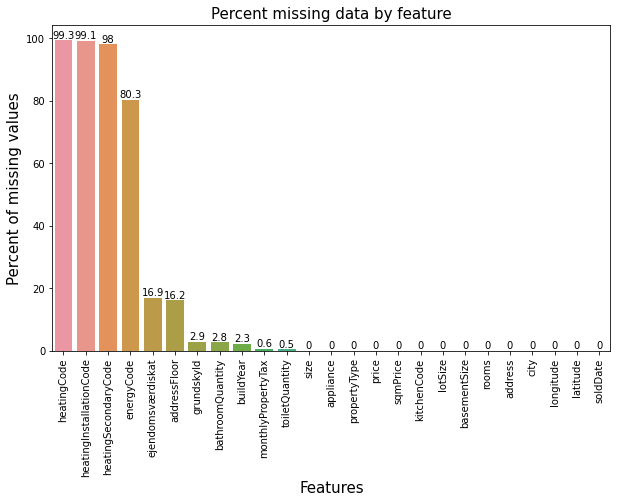

In [9]:
houses = pd.read_parquet('houses_merged.gzip')

# Converting column types automatically
houses.convert_dtypes().dtypes

# Remove duplicate addresses
houses.drop_duplicates(subset=['address'], keep='first')

# Replace missings with NaN's
houses.replace('-', np.NaN, inplace=True)
# Check relevant columns for zero values
zero_columns = ['buildYear', 'ejendomsværdiskat', 'grundskyld', 'monthlyPropertyTax','toiletQuantity', 'bathroomQuantity']
# Assume zeros are missing values and convert to NaN's
houses[zero_columns] = houses[zero_columns].replace({'0':np.nan, 0:np.nan})

# This way, we can count the number of missing values per column;
houses.isnull().sum() 

# As a share of total
shares = houses.isnull().sum(axis=0) * 100 / len(houses)
shares = shares.round(decimals=1).sort_values(ascending=False).to_dict()

# Plot shares of missing values
f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation='90')
sns.barplot(x = list(shares.keys()), y = list(shares.values()))
for i in ax.containers:
    ax.bar_label(i,)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

#Saving picture as .png
plt.savefig('missing_values.png', bbox_inches="tight")

In [10]:
# Drop columns with more than 3 % missing values
list_missings = ['heatingCode', 'heatingInstallationCode', 'heatingSecondaryCode', 'energyCode',
                'ejendomsværdiskat', 'addressFloor']
houses = houses.drop(columns = list_missings)

# Remove missing values
houses = houses.dropna()

# Merge Consumer Price Index with Boliga Data and remove Outliers

**The console that we use is: [console](https://api.statbank.dk/console)**

In [11]:
# Construct API request
def construct_link(table_id, variables):
    base = f'https://api.statbank.dk/v1/data/{table_id}/JSONSTAT?Tid=*'
    
    for var in variables:
        base += f'&{var}'

    return base 

url = construct_link('PRIS116', ['Tid=*'])

def create_data(url):
    response = requests.get(url).json()
    values = response['dataset']['value']
    years = response['dataset']['dimension']['Tid']['category']['index']
    years = list(years)
    data = dict(zip(years, values))
    return data

data = create_data(url)

In [12]:
net_inflation = pd.DataFrame({'years': list(data.keys()), 'net_index': list(data.values())})
net_inflation

,years,net_index
0,1980M01,34.1
1,1980M02,34.4
2,1980M03,34.9
3,1980M04,35.2
4,1980M05,35.8
...,...,...
506,2022M03,110.1
507,2022M04,111.6
508,2022M05,112.7
509,2022M06,113.6


Change baseindex from 2015 to 2021:

In [13]:
net_inflation['2022M07 = 100'] =  round(net_inflation['net_index']/net_inflation['net_index'].iloc[-1]*100,1) 
net_inflation.head(425)

,years,net_index,2022M07 = 100
0,1980M01,34.1,29.6
1,1980M02,34.4,29.9
2,1980M03,34.9,30.3
3,1980M04,35.2,30.6
4,1980M05,35.8,31.1
...,...,...,...
420,2015M01,98.7,85.8
421,2015M02,99.8,86.7
422,2015M03,100.2,87.1
423,2015M04,100.3,87.1


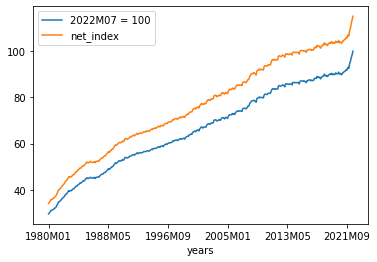

In [14]:
net_inflation.plot(x ='years', y=['2022M07 = 100','net_index']);

In [15]:
net_inflation["years"] = net_inflation["years"].str.replace("M","")
net_inflation

,years,net_index,2022M07 = 100
0,198001,34.1,29.6
1,198002,34.4,29.9
2,198003,34.9,30.3
3,198004,35.2,30.6
4,198005,35.8,31.1
...,...,...,...
506,202203,110.1,95.7
507,202204,111.6,97.0
508,202205,112.7,97.9
509,202206,113.6,98.7


In [16]:
# converting the string to datetime format
net_inflation['years'] = pd.to_datetime(net_inflation['years'], format='%Y%m').dt.year

net_inflation = net_inflation.iloc[::12, :] # COMMENT

inflation_dict = dict(zip(net_inflation.years.astype(int), net_inflation['2022M07 = 100'])) # COMMENT
inflation_dict[2022] = 100

houses['inflation (2022M07 = 100)'] = [inflation_dict[year] for year in pd.to_datetime(houses.soldDate).dt.year]

houses['real_price'] = (houses.price/houses['inflation (2022M07 = 100)'])*100

# Remove outliers based on  sqmPrice after adjusting for CPI
houses['real_sqmPrice'] = (houses.sqmPrice/houses['inflation (2022M07 = 100)'])*100
houses = houses.loc[(houses['real_sqmPrice']<=160000) & (houses['real_sqmPrice']>=10000)]
houses.reset_index(drop = True, inplace = True)

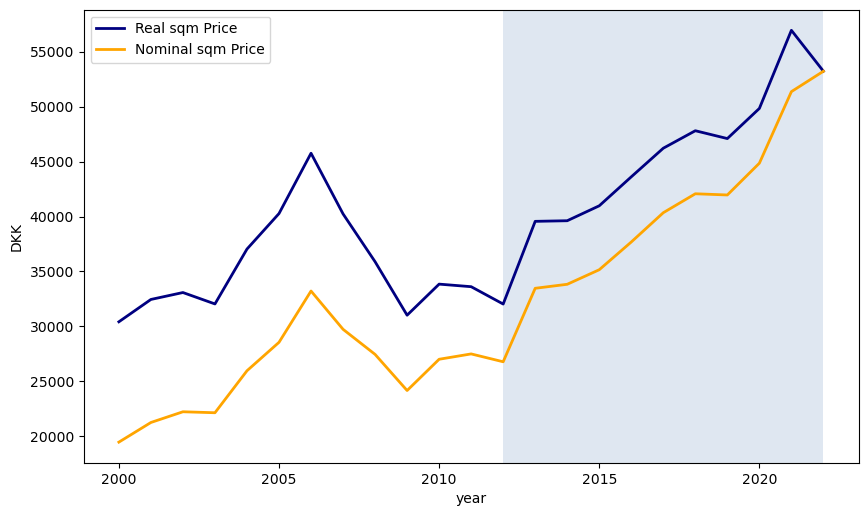

In [17]:

# a. main figure
fig = plt.figure(figsize=(10,6),dpi=100)

# b. customization 
ax = fig.add_subplot(1,1,1)

ax.plot(houses.groupby([pd.to_datetime(houses.soldDate).dt.year])['real_sqmPrice'].mean(),ls='-',lw=2,color='navy',label='Real sqm Price')
ax.plot(houses.groupby([pd.to_datetime(houses.soldDate).dt.year])['sqmPrice'].mean(),ls='-',lw=2,color='orange',label='Nominal sqm Price')

# b. customization 
ax.set_xlabel('year')
ax.set_ylabel('DKK')
ax.grid(False)
ax.axvspan(2012, 2022, facecolor='lightsteelblue', alpha=0.4)
#plt.title('Figure X: Nominal- and real sqm prices adjusted for inflation in the period 2000-2022',fontweight='bold')
ax.legend(loc='upper left',frameon=True);

#Saving picture as .png
plt.savefig('sqm_price.png', bbox_inches="tight")

c:\Users\Kerem\anaconda3\envs\isds\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\Kerem\anaconda3\envs\isds\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Figure size 432x288 with 0 Axes>

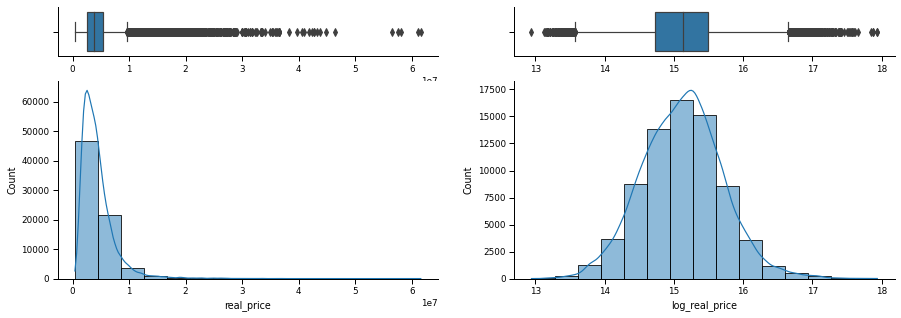

In [18]:
# Transform sqmPrices to logs
houses['log_real_price'] = np.log(houses['real_price'])
# Create year variable to create year dummies
houses['year'] = pd.DatetimeIndex(houses['soldDate']).year
# Drop irrelevant columns

sns.despine()
sns.set_context("paper")
# creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
fig, (ax_box, ax_hist) = plt.subplots(2,2, sharex=False, gridspec_kw={"height_ratios": (.20, .80),}, figsize=(15,5))

# assigning a graph to each ax
sns.boxplot(houses['real_price'], ax=ax_box[0]).set(xlabel=None)
sns.boxplot(houses['log_real_price'], ax=ax_box[1]).set(xlabel=None)

sns.histplot(data=houses['real_price'], bins=15, kde=True, ax=ax_hist[0])
sns.histplot(data=houses['log_real_price'], bins=15, kde=True, ax=ax_hist[1])

#seaborn border settings
sns.despine(top = True, right= True)

#Saving picture as .png
plt.savefig('box_hist_prices.png', bbox_inches="tight")

In [19]:
print(houses.describe().to_latex(index=True))

\begin{tabular}{lrrrrrrrrrrrrrrrrrrr}
\toprule
{} &  propertyType &         price &       sqmPrice &          size &         rooms &     buildYear &      latitude &     longitude &    grundskyld &  monthlyPropertyTax &       lotSize &  basementSize &  toiletQuantity &  bathroomQuantity &  inflation (2022M07 = 100) &    real\_price &  real\_sqmPrice &  log\_real\_price &          year \\
\midrule
count &  73380.000000 &  7.338000e+04 &   73380.000000 &  73380.000000 &  73380.000000 &  73380.000000 &  73380.000000 &  73380.000000 &  7.338000e+04 &        73380.000000 &  73380.000000 &  73380.000000 &    73380.000000 &      73380.000000 &               73380.000000 &  7.338000e+04 &   73380.000000 &    73380.000000 &  73380.000000 \\
mean  &      2.712306 &  3.776863e+06 &   38496.641263 &     97.276901 &      3.312824 &   1943.555288 &     55.678419 &     12.551865 &  2.723472e+04 &         3324.958245 &    129.702766 &     18.073194 &        1.228264 &          1.118520 &               

# Machine Learning

In [20]:
houses = houses.drop(columns = ['price', 'real_price', 'sqmPrice', 'real_sqmPrice', 'inflation (2022M07 = 100)', 'soldDate', 'address', 'latitude', 'longitude'])
houses = houses.query("year >= 2012")
# Categorical variables
cat_var = ['propertyType', 'city', 'appliance', 'kitchenCode', 'year']
houses[cat_var] = houses[cat_var].astype('category')
houses = pd.get_dummies(houses, drop_first=True)

# Create feature matrix and label column
X = houses.drop('log_real_price', axis = 1)
Y = houses['log_real_price']

# Make train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=.5, random_state=2022)

# Create Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

pipe_prep = make_pipeline(PolynomialFeatures(degree=2, include_bias=True),                           
                          StandardScaler())


In [21]:
# houses = houses.drop(columns = ['sqmPrice', 'real_sqmPrice', 'inflation (2022M07 = 100)'])
# # Create matrix of scatterplots
# cols_scatter = ['rooms', 'buildYear', 'city', 'grundskyld', 'monthlyPropertyTax', 'lotSize', 'basementSize',
#                 'appliance', 'toiletQuantity', 'bathroomQuantity', 'kitchenCode', 'year', 'log_real_sqmPrice']
# scatterplotmatrix(houses[cols_scatter].values, figsize=(10, 8), names=cols_scatter, alpha=0.5)

In [22]:
###### Vi skal finde ud af hvordan man laver correlation plots med kategoriske variable - måske Kendall's correlation coefficient
# Create Correlation Matrix
# cm = np.corrcoef(houses[cols_scatter].values.T)
# hm = heatmap(cm, row_names=cols_scatter, column_names=cols_scatter)

# Plotting with GeoPandas and OSM

In [23]:
def ways2poly(ways):
    """
    Given an iterable of `ways`, combined them into one or more polygons.
    
    Args:
        ways: iterable of `overpy.Way` that form the desired polygon:w
        
    Return:
        polys, incomplete: `polys` is a list of list of  (long, lat) coords describing 
            valid (i.e. closed) polygons; `incomplete` is a list of list of (long, lat) 
            coords describing "incomplete polygons" (i.e. LineString)
    """
    w = set(ways)
    polys = []
    incomplete = []
    current = None
    while True:
        if not current:
            if len(w) > 0:
                current = w.pop().nodes
            else:
                break
        if current[0].id == current[-1].id:
            polys.append(current)
            current = None
            continue
        else:
            if len(w) < 1:
                incomplete.append(current)
                break
            to_remove = set()
            for n in w:
                if n.nodes[0].id == current[-1].id:
                    current += n.nodes
                elif n.nodes[0].id == current[0].id:
                    current = list(reversed(n.nodes)) + current
                elif n.nodes[-1].id == current[0].id:
                    current = n.nodes + current
                elif n.nodes[-1].id == current[-1].id:
                    current += list(reversed(n.nodes))
                else:
                    continue
                to_remove.add(n)
            if len(to_remove) == 0:
                incomplete.append(current)
                current = None
                continue
            w -= to_remove

    return polys, incomplete


if __name__ == "__main__":

    queries = dict()
    queries['cph'] = '''
        (rel[boundary="administrative"]["name:en"="Copenhagen Municipality"][admin_level="7"];>;);way(r);(._;>;);out;
    '''
    queries['frb'] = '''
        (rel[boundary="administrative"]["name:en"="Frederiksberg Municipality"][admin_level="7"];>;);way(r);(._;>;);out;
    '''

    # Use overpass to get boundary data (ways) from OSM
    api = overpy.Overpass()
    ways = defaultdict(list)
    for c in queries:
        print('Getting data for {}'.format(c))
        ways[c] = api.query(queries[c])
        print('next')
    print('done')

    # build polygons from the collected data
    boundaries = defaultdict(list)
    for k in ways:
        polys, incmp = ways2poly(ways[k].get_ways())
        boundaries[k] = {'polygons': polys, 'incomplete': incmp}

        if len(polys) > 0 and len(incmp) == 0:
            outcome = 'OK'
        else:
            outcome = 'ERROR'

        print("{}: {:>2} polygons, {:>2} incomplete ({})".format(
            k, len(polys), len(incmp), outcome))

        # I only care about complete polygons, but you could process incomplete
        # ones as (Multi)LineString if needed
        if outcome == 'OK':
            boundaries[k]['shape'] = MultiPolygon(
                [Polygon([(n.lon, n.lat) for n in p]) for p in polys])

    # create GeoDataFrame with the boundaries
    gdf_osm = gpd.GeoDataFrame(
        pd.DataFrame(
            [(k, boundaries[k]['shape']) for k in boundaries
             if 'shape' in boundaries[k].keys()],
            columns=['cc', 'boundary']),
        geometry='boundary')

    # Save a shapefile
    gdf_osm.to_file("missing_boundaries.shp")

Getting data for cph
next
Getting data for frb
next
done
cph: 40 polygons,  0 incomplete (OK)
frb:  1 polygons,  0 incomplete (OK)


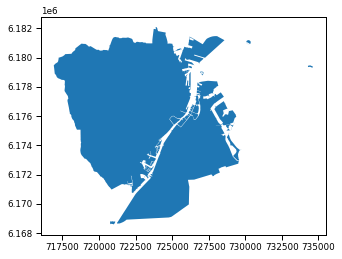

In [24]:
gdf_osm.set_crs(epsg=4326, inplace=True, allow_override=True)
gdf_osm.to_crs(epsg=25832, inplace=True) 
gdf_osm.plot();

In [25]:
# Create geopandas dataframe with shapely points for each housing location
points = houses.apply(lambda row: Point(row['longitude'], row['latitude']), axis = 1) # create housing points
geo_houses = gpd.GeoDataFrame(houses, geometry = points, crs = 'EPSG:4326') 
geo_houses.to_crs(epsg=25832, inplace=True) # this epsg code uses meters as unit measure

fig, ax = plt.subplots(figsize=(20, 15))

# Copenhagen Area base plot
gdf_osm.plot(color='#d7d7d7',edgecolor='black', ax=ax, label = "Copenhagen Area")

# plot houseprices
geo_houses.plot(ax=ax, color = "blue", markersize=2,  label = "Sold apartments")

# narrow xlim
ax.set_xlim([716000, 730000]) # based on north eastern epsg: 25832
ax.set_axis_off()
ax.set_title(f'Apartments sold in Copenhagen and Frederiksberg municipality {year_from}-{date.today()}', fontsize=22)

# handle legend 
lgnd = fig.legend(loc=7, ncol=1, fontsize = 15)    
lgnd.legendHandles[0]._sizes = [40]


fig.subplots_adjust(right=0.95) 

KeyError: 'longitude'

# Load Spatial Attributes

## 1) Charging Stations (EV)
One of the chosen spatial attributes is charging stations for electric vehicles. We import data from opendata.com on charging stations in the municpality of Copenhagen and Frederiksberg, respectively.

### Charging Stations Frederiksberg

Due to continous update of the id on the [charging station data]( https://www.opendata.dk/city-of-frederiksberg/elbil-ladestandere) provided by municipality of Frederiksberg we have downloaded the GeoJson file and uploaded it to a public github repository from which we fetch the data.

In [ ]:
url = 'https://raw.githubusercontent.com/HansChristianPOLIT/geojson_isds2022/main/charging_stations_frederiksberg.geojson'
charging_stations_frb = gpd.read_file(url)

# Inspect data
charging_stations_frb.head() 

Clean data and keep relevant information:

In [ ]:
charging_stations_frb.rename(columns = {'gid':'id', 'adgangsadresse':'address'}, inplace = True) # rename relevant columns to english
charging_stations_frb = charging_stations_frb[['id', 'address','geometry']] # keep only relevant columns
charging_stations_frb.head()

### Charging Stations Municipality of Copenhagen

We use [data](https://www.opendata.dk/city-of-copenhagen/ladestandere-elbil) from opendata.dk provided by Municipality of Copenhagen.

In [ ]:
url = 'https://wfs-kbhkort.kk.dk/k101/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=k101:elbil_ladestander_i_drift&outputFormat=application%2Fjson&srsname=epsg:4326'
charging_stations_cph = gpd.read_file(url)

charging_stations_cph.head() # Inspect data

In [ ]:
charging_stations_cph.rename(columns={'vejnavn':'address'}, inplace=True) # rename relevant columns to english
charging_stations_cph = charging_stations_cph[['id', 'address','geometry']]
#charging_stations_cph

### Concatenate
We merge the data to create dataFrame of the total EV charging stations in the Copenhagen Area. 

In [ ]:
combine_dfs = [charging_stations_cph, charging_stations_frb]
charging_stations_total = pd.concat(combine_dfs)
charging_stations_total.reset_index(inplace=True, drop=True) # <-- reset index

charging_stations_total # view merged data

### Extract lattitude and longitude of geometry column

To extract lattitude and longitude we will use `regex`, therefore we import the following package:

In [ ]:
# Import package
import re

In [ ]:
charging_stations_total['geometry_str'] = charging_stations_total['geometry'].astype(str) # convert to str to leverage `re`
charging_stations_total

Thereafter, we find the pattern and create a function to extract the 2 regex *groups* from the geometry_str column:

In [ ]:
# define reg pattern
lat_lng_pattern = re.compile(r"\((.*) \s*(.*)\)")

# define function for extraction 
def extract_lng_lat(address):
    """ Takes coordinates as input and search for the longitude and lattitude using regular expression.

        Parameter
        ----------
        arg : coordinates 

        Returns
        -------
        tuple of longitude and lattitude
    """
    try: 
        lng_lat_match = lat_lng_pattern.search(address)
        lng = float(lng_lat_match.group(1))
        lat = float(lng_lat_match.group(2))
        return (lng,lat)
    except:
        return (np.NaN, np.NaN)

Apply the regular expression function on the dataFrame:

In [ ]:
lng_lats = [extract_lng_lat(location) for location in charging_stations_total.loc[:,'geometry_str']]
charging_stations_total['lng'] = [lat for lat, lng in lng_lats]
charging_stations_total['lat'] =  [lng for lat, lng in lng_lats]

charging_stations_total = charging_stations_total.drop('geometry_str', axis=1) # drop irrelevant column
charging_stations_total.head() # Inspect result

## 2) Metrostations

We use [data](https://www.opendata.dk/city-of-copenhagen/oversigtskort) on metrostations from opendata.dk provided by Municipality of Copenhagen.

In [ ]:
url = 'https://wfs-kbhkort.kk.dk/k101/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=k101:station_oversigtskort&outputFormat=json&SRSNAME=EPSG:4326' 
stations = gpd.read_file(url)

#stations.head(60) # Inspect data

In [ ]:
# Fetch only metrostations
metrostations = stations.loc[(stations['objekt_type'] == 'Metrostation')]

# Remove the station in Municpality of Tårnby
metrostations = metrostations[metrostations.kommune != 'Tårnby']

metrostations.rename(columns = {'navn':'address','kommune':'municipality'}, inplace = True)
metrostations.reset_index(drop=True,inplace=True)
metrostations['geometry_str'] = metrostations['geometry'].astype(str) # create new str column for regular expression
metrostations.head() # <-- inspect data

Apply the regular expression function on the metrostations dataFrame:

In [ ]:
lng_lats = [extract_lng_lat(location) for location in metrostations.loc[:,'geometry_str']]
metrostations['lng'] = [lat for lat, lng in lng_lats]
metrostations['lat'] =  [lng for lat, lng in lng_lats]

metrostations = metrostations.drop('geometry_str', axis=1) # drop irrelevant column
metrostations.head() # Inspect result

## 3) Restaurants
In order to select custom features from the OpenStreetMap we use the [Overpass API](https://wiki.openstreetmap.org/wiki/Overpass_API). To query Overpass API in Python we use the wrapper [overpy](https://github.com/DinoTools/python-overpy).

In [ ]:
api = overpy.Overpass()

### Restaurants in the Municipality of Frederiksberg

Fetch restaurants in Frederiksberg from OpenStreetMaps:

In [ ]:
query_result = api.query("""
area["wikidata" = "Q2488464"]->.place;   
node["amenity"="restaurant"](area.place);
out body;
""") # Q2488464 defines borders of Frederiksberg in OpenStreetMap (OSM)

We convert nodes from OSM into GeoDataFrame:

In [ ]:
# We need to turn lng & lat into shapely points on globe
points_array = [ Point(x.lon, x.lat) for x in query_result.nodes]
points_series = gpd.GeoSeries(points_array)

restaurant_array = [ { 
    "name": x.tags.get("name", "")
} for x in query_result.nodes]

restaurants_frb = gpd.GeoDataFrame(restaurant_array, geometry=points_series, crs=4326) # save as gdf
restaurants_frb # inspect result 

### Restaurants in the Municipality of Copenhagen

In [ ]:
query_result = api.query("""
area["wikidata" = "Q504125"]->.place;   
node["amenity"="restaurant"](area.place);
out body;
""") # Q504125 defines borders of Municipality of Copenhagen in OpenStreetMap (OSM)

In [ ]:
points_array = [ Point(x.lon, x.lat) for x in query_result.nodes]
points_series = gpd.GeoSeries(points_array)

restaurant_array = [ { 
    "name": x.tags.get("name", "")
} for x in query_result.nodes]

restaurants_cph = gpd.GeoDataFrame(restaurant_array, geometry=points_series, crs=4326)
restaurants_cph # inspect result 

#### Concatenate Restaurant Data

In [ ]:
combine_restaurants = [restaurants_cph, restaurants_frb]
restaurants_total = pd.concat(combine_restaurants)
restaurants_total.reset_index(inplace=True, drop=True) # <-- reset index
restaurants_total['geometry_str'] = restaurants_total['geometry'].astype(str)
#restaurants_total # inspect data

Apply regular expression function to extract longitude and lattiude:

In [ ]:
lng_lats = [extract_lng_lat(location) for location in restaurants_total.loc[:,'geometry_str']]
restaurants_total['lng'] = [lat for lat, lng in lng_lats]
restaurants_total['lat'] =  [lng for lat, lng in lng_lats]
restaurants_total = restaurants_total.drop('geometry_str', axis=1) # remove irrelevant column
restaurants_total.head()

## 4) Malls 

In the following we make a "workaround" to extract ways and relations from OSM via Overpass API:

### Malls on Frederiksberg

In [ ]:
response = requests.get('https://overpass-api.de/api/interpreter?data=[out:xml][timeout:25];(area["wikidata"="Q2488464"]->.place;node["shop"="mall"](area.place);way["shop"="mall"](area.place);relation["shop"="mall"](area.place););out geom;')

string_frb = response.text.replace("\n","")
geojson_malls_frb = osm2geojson.xml2geojson(string_frb) # convert the XML to Geojson using osm2geojson

malls_frb = gpd.GeoDataFrame.from_features(geojson_malls_frb["features"])
malls_frb = malls_frb.drop([0]) # <-- redundant node 
malls_frb.rename(columns = {'tags':'name'}, inplace = True)

malls_frb['name'] = 'Frederiksberg Centret'
malls_frb # view result

Extract lattitude and longitude using an anonymous function:
- note to calculate distances to a polygon we use the center coordinate as reference point, therefore, we apply the method *centroid*.

In [ ]:
# extract coordinates
malls_frb["lng"] = malls_frb.centroid.map(lambda p: p.x)
malls_frb["lat"] = malls_frb.centroid.map(lambda p: p.y)

# convert latitude/longtitude columns to Geometry Column using Python using list comprehsion
#malls_frb['geometry_center_point'] = [Point(xy) for xy in zip(malls_frb['lng'], malls_frb['lat'])]

malls_frb.set_crs(epsg=4326, allow_override=True)
malls_frb

### Malls in Copenhagen

In [ ]:
# make a request to overpass and return XML
response = requests.get('https://overpass-api.de/api/interpreter?data=[out:xml][timeout:25];(area["wikidata"="Q504125"]->.place;node["shop"="mall"](area.place);way["shop"="mall"](area.place);relation["shop"="mall"](area.place););out geom;')

string = response.text.replace("\n","")
geojson_malls_cph = osm2geojson.xml2geojson(string) # convert the XML to Geojson using osm2geojson

malls_cph = gpd.GeoDataFrame.from_features(geojson_malls_cph["features"])
malls_cph = malls_cph.drop([6]) # <-- misplaced as mall on OSM
malls_cph.rename(columns = {'tags':'name'}, inplace = True)

newcol = ['Fisketorvet','Fields', 'Nørrebro Bycenter', 'Spinderiet', 'Amager Centret', 'Kronen Vanløse','Illum'] 
malls_cph['name'] = newcol
malls_cph # inspect result

In [ ]:
malls_cph["lng"] = malls_cph.centroid.map(lambda p: p.x)
malls_cph["lat"] = malls_cph.centroid.map(lambda p: p.y)

#malls_cph['geometry_center_point'] = [Point(xy) for xy in zip(malls_cph['lng'], malls_cph['lat'])]

malls_cph.set_crs(epsg=4326, allow_override=True)
malls_cph # view results

### Concatenate

In [ ]:
combine_malls = [malls_cph, malls_frb]
malls_total = pd.concat(combine_malls)
malls_total = malls_total.drop('type', axis=1) # drop irrelevant column
malls_total = malls_total.drop('id', axis=1) # drop irrelevant column
malls_total.reset_index(inplace=True, drop=True) # <-- reset index
malls_total

## 5) Parks
- Again, we use a "workaround" to extract (multi)poylgon geometric data from OSM.

### Park Data on Frederiksberg

In [ ]:
response = requests.get('https://overpass-api.de/api/interpreter?data=[out:xml][timeout:25];(area["wikidata" = "Q2488464"]->.place;way["leisure"="park"](area.place););out geom;')

string_frb = response.text.replace("\n","")
geojson_park_frb = osm2geojson.xml2geojson(string_frb)

parks_frb = gpd.GeoDataFrame.from_features(geojson_park_frb["features"])
parks_frb.rename(columns = {'tags':'name'}, inplace = True)
parks_frb # inspect result

### Park Data on Copenhagen

In [ ]:
response = requests.get('https://overpass-api.de/api/interpreter?data=[out:xml][timeout:25];(area["wikidata" = "Q504125"]->.place;way["leisure"="park"](area.place););out geom;')

string_cph = response.text.replace("\n","")
geojson_park_cph = osm2geojson.xml2geojson(string_cph)

parks_cph = gpd.GeoDataFrame.from_features(geojson_park_cph["features"])
parks_cph.rename(columns = {'tags':'name'}, inplace = True)
parks_cph # inspect result

### Concatenate

In [ ]:

combine_parks = [parks_frb, parks_cph]
parks_total = pd.concat(combine_parks)
parks_total.reset_index(inplace=True, drop=True) # reset index
parks_total

Because a lot of polygons in OSM is defined as parks, we choose to keep only parks that have a name tag:

In [ ]:
name_parks = [d.get('name') for d in parks_total.name]
parks_total['name'] = name_parks

parks_total = parks_total[parks_total.name.notnull()] # remove parks with no name tag
parks_total = parks_total[parks_total.name != 'Kastrup Strandpark'] # remove because not park of cph nor frb
parks_total = parks_total[parks_total.name != 'Høje Gladsaxe Park'] # remove because not park of cph nor frb
parks_total = parks_total.drop('type', axis=1) # drop irrelevant column
parks_total = parks_total.drop('id', axis=1) # drop irrelevant column

parks_total.reset_index(drop=True)

### Extract Longitude and Lattitude of Parks

In [ ]:
parks_total["lng"] = parks_total.centroid.map(lambda p: p.x)
parks_total["lat"] = parks_total.centroid.map(lambda p: p.y)

#parks_total['geometry_center_point'] = [Point(xy) for xy in zip(parks_total['lng'], parks_total['lat'])]
parks_total

## 6) Harbor Baths
- The purpose of this automation tool is to extract addresses, lattitudes, and longitudes on "harbor baths" in Copehangen

In [ ]:
# Import packages
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By

In [ ]:
url = 'https://www.visitcopenhagen.dk/koebenhavn/aktiviteter/havnebade-og-strande'
driver = webdriver.Chrome(ChromeDriverManager().install())
driver.implicitly_wait(40) #Waits maximum 100 seconds for an element to be found in the HTML.
driver.get(url)

# We need to click away the popup box with cookie information
driver.find_element(By.CSS_SELECTOR, ".coi-banner__accept").click()

In [ ]:
index_list=[1,2,3,4,5,6,8,9,10,11,13]

# Intialize lists
places_list = []
coordinates_list = []

In [ ]:
for i in index_list:
    # Locate Specific Information we are Scraping 
    driver.find_element(By.XPATH, f'//div[{i}]/div/div/div/div/div/div/a[@class="GuideItemUi__MoreInfo-im3577-9 goOBMS link-internal"]').click()
    places = driver.find_element(By.XPATH, '//h1[@class="Product__Title-sc-127atq4-13 iuYfEn"]').text
    places_list.append(places)

    coord_btn = driver.find_element(By.XPATH, "//button[contains(text(), 'Koordinater')]").click()

    coordinates = driver.find_element(By.XPATH, '//div[@class="Coordinates__Wrapper-pk556h-0 bdffic panel-info-wrap"]').text
    coordinates_list.append(coordinates)

    #back to previous page with back()
    driver.back()

In [ ]:
# convert lists to a dictionary
dict_harbor_baths = dict(zip(places_list, coordinates_list))
print(dict_harbor_baths)

### Data Cleaning

In [ ]:
# convert dictionary to dataFrame
harbor_baths = pd.DataFrame.from_dict(dict_harbor_baths, orient='index')
harbor_baths.rename( columns={0 :'geometry'}, inplace=True )

harbor_baths['address']=harbor_baths.index
harbor_baths.reset_index(drop=True) 

Extract Lattitudes and Longitudes:

In [ ]:
# define reg pattern
lat_lng_pattern = re.compile(r"((\d{1,3},\d{3}(,\d{3})*)(\.\d*)?|\d+\.?\d*)")

# redefine function for extraction 
def extract_lng_lat(address):
    try: 
        lng_lat_match = lat_lng_pattern.search(address)
        lng = float(lng_lat_match.group(0)) # <-- changed 
        lat = float(lng_lat_match.group(0))
        return (lng,lat)
    except:
        return (np.NaN, np.NaN)

In [ ]:
# create str column for extraction of lat and lng
harbor_baths['geometry_str'] = harbor_baths['geometry'].astype(str) 

# apply function from earlier
lng_lats = [extract_lng_lat(location) for location in harbor_baths.loc[:,'geometry_str']]
harbor_baths['lng'] = [lat for lat, lng in lng_lats]

#harbor_baths.head() 

In [ ]:
# reuse reg pattern
lat_lng_pattern = re.compile(r"[0-9]*\.[0-9]+")
harbor_baths['geometry_str'] = harbor_baths['geometry_str'].str[25:] # ensures lattitude is matched

# apply function from earlier
lng_lats = [extract_lng_lat(location) for location in harbor_baths.loc[:,'geometry_str']]
harbor_baths['lat'] =  [lng for lat, lng in lng_lats]

harbor_baths = harbor_baths.drop('geometry_str', axis=1) # drop irrelevant column
harbor_baths = harbor_baths.drop('geometry', axis=1) # drop irrelevant column
harbor_baths.reset_index(drop=True, inplace=True) 
harbor_baths.head() # inspect data

## Schools

### School Data Frederiksberg

In [ ]:
response = requests.get('https://overpass-api.de/api/interpreter?data=[out:xml][timeout:25];(area["wikidata"="Q2488464"]->.place;node["amenity"="school"](area.place);relation["amenity"="school"](area.place);way["amenity"="school"](area.place););out geom;')

string_frb = response.text.replace("\n","")
geojson_school_frb= osm2geojson.xml2geojson(string_frb)

schools_frb = gpd.GeoDataFrame.from_features(geojson_school_frb["features"])
schools_frb.rename(columns = {'tags':'name'}, inplace = True)
schools_frb # inspect result

In [ ]:
name_schools = [d.get('name') for d in schools_frb.name]
schools_frb['name'] = name_schools

In [ ]:
schools_frb["lng"] = schools_frb.centroid.map(lambda p: p.x)
schools_frb["lat"] = schools_frb.centroid.map(lambda p: p.y)

In [ ]:
schools_frb.drop([1, 3,4,5,6,11,15], inplace=True)
schools_frb = schools_frb.drop(['type','id'],axis=1)
schools_frb.reset_index(drop=True)

### School Data on Municipality of Copenhagen

In [ ]:
response = requests.get('https://overpass-api.de/api/interpreter?data=[out:xml][timeout:25];(area["wikidata"="Q504125"]->.place;node["amenity"="school"](area.place);relation["amenity"="school"](area.place);way["amenity"="school"](area.place););out geom;')

string_cph = response.text.replace("\n","")
geojson_school_cph= osm2geojson.xml2geojson(string_cph)

schools_cph = gpd.GeoDataFrame.from_features(geojson_school_cph["features"])
schools_cph.rename(columns = {'tags':'name'}, inplace = True)
schools_cph # inspect result

In [ ]:
name_schools = [d.get('name') for d in schools_cph.name]
schools_cph['name'] = name_schools

In [ ]:
schools_cph["lng"] = schools_cph.centroid.map(lambda p: p.x)
schools_cph["lat"] = schools_cph.centroid.map(lambda p: p.y)

In [ ]:
schools_cph.drop(schools_cph.index[14:26], inplace=True)
schools_cph.drop([0,2,3,6,7,8,9,12,26,27,28,29,30,34,38,52,60], inplace=True)
schools_cph.drop([92,94,99,104,107,108,111,112,113,114,127,128,132,134], inplace=True)
schools_cph = schools_cph[schools_cph.name.notnull()] # remove None values
schools_cph = schools_cph.drop(['type','id'],axis=1)
schools_cph.reset_index(drop=True)

### Concatenate

In [ ]:
combine_schools = [schools_frb, schools_cph]
schools_total = pd.concat(combine_schools)
schools_total.reset_index(inplace=True, drop=True) # reset index
schools_total

# Change Projections of Spatial Attributes to Calculate Distances

To calculate correct distances, we need to specify the correct projection:

In [ ]:
# make a GeoDataFrame of charging station data
gdf_charging_stations_total = gpd.GeoDataFrame(
    charging_stations_total, geometry=gpd.points_from_xy(charging_stations_total.lng, charging_stations_total.lat), crs = {'init': 'epsg:4326'})
gdf_charging_stations_total.to_crs(epsg=25832, inplace=True) # <-- to eastern northing

# make a GeoDataFrame of metrostation data
gdf_metrostations = gpd.GeoDataFrame(
    metrostations, geometry=gpd.points_from_xy(metrostations.lng, metrostations.lat), crs = {'init': 'epsg:4326'})
gdf_metrostations.to_crs(epsg=25832, inplace=True)    # change projection to eastern northing

# make a GeoDataFrame of restaurant data
gdf_restaurants_total = gpd.GeoDataFrame(
    restaurants_total, geometry=gpd.points_from_xy(restaurants_total.lng, restaurants_total.lat), crs = {'init': 'epsg:4326'})
gdf_restaurants_total.to_crs(epsg=25832, inplace=True) # <-- to eastern northing

# make a GeoDataFrame of mall data
gdf_malls_total = gpd.GeoDataFrame(
    malls_total, geometry=gpd.points_from_xy(malls_total.lng, malls_total.lat), crs = {'init': 'epsg:4326'})
gdf_malls_total.to_crs(epsg=25832, inplace=True) # <-- to eastern northing

# make a GeoDataFrame of park data
gdf_parks_total = gpd.GeoDataFrame(
    parks_total, geometry=gpd.points_from_xy(parks_total.lng, parks_total.lat), crs = {'init': 'epsg:4326'})
gdf_parks_total.to_crs(epsg=25832, inplace=True) # <-- to eastern northing

# make a GeoDataFrame of harbor bath data
gdf_harbor_baths = gpd.GeoDataFrame(
    harbor_baths, geometry=gpd.points_from_xy(harbor_baths.lng, harbor_baths.lat), crs = {'init': 'epsg:4326'})
gdf_harbor_baths.to_crs(epsg=25832, inplace=True) # <-- to eastern northing

# make a GeoDataFrame of school data
gdf_schools = gpd.GeoDataFrame(
    schools_total, geometry=gpd.points_from_xy(schools_total.lng, schools_total.lat), crs = {'init': 'epsg:4326'})
gdf_schools.to_crs(epsg=25832, inplace=True) # <-- to eastern northing

# Plotting Spatial Attributes

In [ ]:
houses

In [ ]:
fig, ax = plt.subplots(figsize=(20, 15))

# basemap of Copenhagen Area
gdf_osm.plot(color='#d7d7d7',edgecolor='black', ax=ax, label = "Copenhagen Area")

# plot houseprices
geo_houses.plot(ax=ax, color = "blue", markersize=2,  label = "Sold apartments")

# plot metrostations
metrostations.plot(ax=ax, color = "red", markersize=10,  label = "Metrostations")

# plot charging stations
charging_stations_total.plot(ax=ax, color = "green", markersize=8,  label = "EV Charging Stations")

# plot restaurants
restaurants_total.plot(ax=ax, color = "orange", markersize=10,  label = "Restaurants")

# plot malls
malls_total.plot(ax=ax, color = "pink",  label = "Malls")

# plot parks
parks_total.plot(ax=ax, color = "brown",  label = "Parks")

# plot harbor baths
gdf_harbor_baths.plot(ax=ax, color = "black",  label = "Harbor Baths")

# plot schools
gdf_schools.plot(ax=ax, color = "lightsteelblue",  label = "Schools")

# narrow xlim
ax.set_xlim([716000, 730000])
ax.set_axis_off()
ax.set_title(f'Apartments sold in Copenhagen and Frederiksberg municipality {year_from}-{date.today()} & Local Attributes', fontsize=22)

# handle legend 
lgnd = fig.legend(loc=7, ncol=1, fontsize = 15)    
lgnd.legendHandles[0]._sizes = [40]


fig.subplots_adjust(right=0.95)

In [ ]:
# Read in the zip code GeoJson file from Github and look at the first few rows.
url = "https://raw.githubusercontent.com/ok-dk/dagi/master/geojson/postnumre.geojson" 
zip_code = gpd.read_file(url)

# Use correct coordinate reference system
#zipcode.to_crs(epsg=25832, inplace=True) 

# inspect data
zip_code.head()

In [ ]:
# Fetch zip codes the for municipalities of Copenhagen and Frederiksberg

cph_list = ['København K', 'København Ø', 'København V', 'København SV', 'København NV', 'København N', 'København S', 'Vanløse', 'Brønshøj', 'Valby', 'Frederiksberg', 'Frederiksberg C'] 
houses = houses.loc[houses['city'].isin(cph_list)]
zip_code = zip_code.loc[zip_code['POSTBYNAVN'].isin(cph_list)]

In [ ]:
zip_code.set_crs(epsg=4326, inplace=True, allow_override=True)
zip_code.to_crs(epsg=25832, inplace=True) 

In [ ]:
fig, ax = plt.subplots(figsize=(20, 15))

# basemap of Copenhagen Area
gdf_osm.plot(color='#d7d7d7',edgecolor='black', ax=ax, label = "Copenhagen Area")

zip_code.plot(color='#d7d7d7',edgecolor='black', ax=ax)

# plot houseprices
geo_houses.plot(ax=ax, color = "blue",  markersize=2, label = "Sold apartments")
#geo_houses.plot(ax=ax, alpha = .1)

# plot metrostations
metrostations.plot(ax=ax, color = "red", markersize=10,  label = "Metrostations")

# plot charging stations
charging_stations_total.plot(ax=ax, color = "green", markersize=8,  label = "EV Charging Stations")

# plot restaurants
restaurants_total.plot(ax=ax, color = "orange", markersize=10,  label = "Restaurants")

# plot malls
malls_total.plot(ax=ax,marker="s", color = "pink",  label = "Malls")

# plot parks
parks_total.plot(ax=ax, marker="v", color = "brown",  label = "Parks")

# plot harbor baths
gdf_harbor_baths.plot(ax=ax, color = "black",  label = "Harbor Baths")

# plot schools
gdf_schools.plot(ax=ax, color = "lightsteelblue",  label = "Schools")

# narrow xlim
ax.set_xlim([716000, 730000])
ax.set_axis_off()
ax.set_title(f'Apartments sold in Copenhagen and Frederiksberg municipality {year_from}-{date.today()} & Local Attributes', fontsize=22)

# handle legend 
lgnd = fig.legend(loc=7, ncol=1, fontsize = 15)    
lgnd.legendHandles[0]._sizes = [40]


fig.subplots_adjust(right=0.95)

# Calculate Distances

To utilize vectorization of the search of nearest distance we use `scipy`'s `cKDTree spatial index` `.query` method instead of looping through all spatial attributes and finding the one with nearest distance.

In [ ]:
# Import packages 
from scipy.spatial import cKDTree
from shapely.geometry import Point

**Define function:**

In [ ]:
def ckdnearest(gdfA, gdfB):
    """ Takes geopandasdataframe as input and find the nearest distance between the two for each row.

        Parameter
        ----------
        arg1 : GeoDataFrame_1
        arg2 : GeoDataFrame_2

        Returns
        -------
        GeoDataFrame
    """
    nA = np.array(list(gdfA.geometry.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdfB.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdfB_nearest = gdfB.iloc[idx].drop(columns="geometry").reset_index(drop=True)
    gdf = pd.concat(
        [
            gdfA.reset_index(drop=True),
            gdfB_nearest,
            pd.Series(dist, name='nearest_dist')
        ], 
        axis=1)

    return gdf

In [ ]:
nearest_charging_station = ckdnearest(geo_houses, gdf_charging_stations_total)
nearest_metrostation = ckdnearest(geo_houses, gdf_metrostations)
nearest_restaurant = ckdnearest(geo_houses, gdf_restaurants_total)
nearest_mall = ckdnearest(geo_houses, gdf_malls_total)
nearest_park = ckdnearest(geo_houses, gdf_parks_total)
nearest_harbor_bath = ckdnearest(geo_houses, gdf_harbor_baths)
nearest_school = ckdnearest(geo_houses, gdf_schools)

In [ ]:
# keep relevant columns & rename
nearest_charging_station = nearest_charging_station.iloc[:,-4:]
nearest_charging_station.rename(columns={'nearest_dist':'nearest_dist_charging_station'}, inplace = True) 

nearest_metrostation = nearest_metrostation.iloc[:,-5:]
nearest_metrostation.rename(columns={'nearest_dist':'nearest_dist_metrostation'}, inplace = True) 

nearest_restaurant = nearest_restaurant.iloc[:,-4:]
nearest_restaurant.rename(columns={'nearest_dist':'nearest_dist_restaurant'}, inplace = True) 

nearest_mall = nearest_mall.iloc[:,-4:]
nearest_mall.rename(columns={'nearest_dist':'nearest_dist_mall'}, inplace = True) 

nearest_park = nearest_park.iloc[:,-4:]
nearest_park.rename(columns={'nearest_dist':'nearest_dist_park'}, inplace = True) 

nearest_harbor_bath = nearest_harbor_bath.iloc[:,-4:]
nearest_harbor_bath.rename(columns={'nearest_dist':'nearest_dist_bath'}, inplace = True) 

nearest_school = nearest_school.iloc[:,-4:]
nearest_school.rename(columns={'nearest_dist':'nearest_dist_school'}, inplace = True) 

In [ ]:
geo_houses.reset_index(level=0, inplace=True) # reset index to allow merge

pd1 = pd.merge(geo_houses, nearest_charging_station, left_index=True, right_index=True)
pd2 = pd.merge(pd1, nearest_metrostation, left_index=True, right_index=True)
pd3 = pd.merge(pd2, nearest_restaurant, left_index=True, right_index=True)
pd4 = pd.merge(pd3, nearest_mall, left_index=True, right_index=True)
pd5 = pd.merge(pd4, nearest_park, left_index=True, right_index=True)
pd6 = pd.merge(pd5, nearest_school, left_index=True, right_index=True)
merged_geo_houses = pd.merge(pd6, nearest_harbor_bath, left_index=True, right_index=True)
merged_geo_houses

# Descriptive Analysis

## Heat Map

`sjoin()`

In [ ]:
zip_code_expl = zip_code.sjoin(merged_geo_houses)
zip_code_expl.head()

In [ ]:
zip_code_expl_mean_price = zip_code_expl.groupby(['POSTBYNAVN'])['real_price'].mean().sort_values(ascending=False)
zip_code_expl_mean_price = zip_code_expl_mean_price.to_frame()

In [ ]:
# Reset index and column names
zip_code_expl_mean_price.reset_index(inplace=True)
zip_code_expl_mean_price.columns = ['POSTBYNAVN', 'real_Price_mean']
zip_code_expl_mean_price.head()

In [ ]:
# Merge zip codes and ladestander_by_zipcode_counts_df: 
zipcode_and_mean_Price = pd.merge(zip_code_expl,zip_code_expl_mean_price, on = 'POSTBYNAVN')
zipcode_and_mean_Price.head()

In [ ]:
zipcode_and_mean_Price.plot(column = 'real_Price_mean', legend = True)

In [ ]:
fig, ax = plt.subplots(figsize=(20, 15))


# basemap of Copenhagen Area
#gdf_osm.plot(color='#d7d7d7',edgecolor='black', ax=ax, label = "Copenhagen Area")

zipcode_and_mean_Price.plot(column = 'real_Price_mean', cmap="Reds",ax=ax, legend=True)

# plot houseprices
merged_geo_houses.plot(ax=ax, color = "blue",  markersize=2, label = "Sold apartments", alpha=0.5)

# narrow xlim
ax.set_xlim([716000, 730000])
ax.set_axis_off()
ax.set_title(f'Apartments sales & prices of zip codes', fontsize=22)

# handle legend 
#lgnd = fig.legend(loc=7, ncol=1, fontsize = 15)    
#lgnd.legendHandles[0]._sizes = [40]


fig.subplots_adjust(right=0.95)

## Scatterplots

In [ ]:
from mlxtend.plotting import scatterplotmatrix

**We are interest in the period 2012 - presence**

In [ ]:
houses = houses.loc[(houses['year'] >= 2012)]

In [ ]:
# Create matrix of scatterplots
cols_scatter = ['rooms', 'buildYear', 'grundskyld', 'monthlyPropertyTax', 'lotSize', 
                'basementSize', 'toiletQuantity', 'bathroomQuantity','year', 'size','log_real_price']
scatterplotmatrix(houses[cols_scatter].values, figsize=(30, 24), names=cols_scatter, alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
from mlxtend.plotting import heatmap

In [ ]:
plt.rcParams['figure.figsize'] = (20, 10)


cm = np.corrcoef(houses[cols_scatter].values.T)
hm = heatmap(cm,
row_names=cols_scatter,
column_names=cols_scatter)
plt.show()

#### Looking at a particular year (2021)

In [ ]:
houses2 = houses.loc[(houses['year'] == 2021)]

In [ ]:
# Create matrix of scatterplots
cols_scatter = ['rooms', 'buildYear', 'grundskyld', 'monthlyPropertyTax', 'lotSize', 
                'basementSize', 'toiletQuantity', 'bathroomQuantity', 'size','log_real_price']
scatterplotmatrix(houses2[cols_scatter].values, figsize=(30, 24), names=cols_scatter, alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
cm = np.corrcoef(houses2[cols_scatter].values.T)
hm = heatmap(cm,
row_names=cols_scatter,
column_names=cols_scatter)
plt.show()